In [1]:
# Staple  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns

# Misc  
import re  
import itertools  
import os  
import joblib  
from tqdm.notebook import tqdm  
from IPython.display import HTML
import pickle
import os
import sys
import time

# NLP  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize, RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy

# Clustering  
from sklearn.decomposition import PCA, TruncatedSVD  
from sklearn.cluster import (KMeans,  AgglomerativeClustering,  
                             DBSCAN, OPTICS, cluster_optics_dbscan)  
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (calinski_harabasz_score, silhouette_score,
                            silhouette_score, davies_bouldin_score)

# hyperparameter tuning
from yellowbrick.cluster.elbow import kelbow_visualizer
from kneed import KneeLocator

import sqlite3
# import plotly.express.px

# fast cluster
import fastcluster

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1nn_7zpw because the default path (/home/nlim/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 13:15:34.413647: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 13:15:34.413713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-nlim
2023-02-08 13:15:34.413725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-nlim
2023-02-08 13:15:34.413869: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-08 13:15:34.413905: I tensorflow/

In [2]:
def save_pkl(obj, name, prompt=False):
    """
    Save an object to a pickle file.
    
    """
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)
    if prompt:
        print('Object pickled for future use.')
    return

In [3]:
def load_pkl(obj, name):
    
    """Load an object from a pickle file."""
    
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    return joblib.load(fp)

## Importing database

In [4]:
db_path = '/mnt/processed/private/msds2023/slt5a/lab1/ssot/amazon.db'  
conn = sqlite3.connect(db_path)

In [5]:
amz_dict = {}

for date in ['2012-12', '2013-12' ,'2014-12']:
    query = f"""
        SELECT * 
        FROM amazon_main  
        WHERE review_date LIKE '%{date}%'
        """
    amz_dict.update({int(date[:4]): pd.read_sql(query, conn)})

In [6]:
amz_2014 = amz_dict[2014]

In [19]:
amz_2014.head()

,review_id,review_date,customer_id,product_id,product_title,star_rating,review_headline,review_body
0,R23K7QNHEMI5Q9,2014-12-31,12450911,B003D0WM8W,Chocolate River Stones (1lb Bag),5,Five Stars,Always a huge hit!
1,R11CMHYGHB0HIE,2014-12-31,8428967,B001C316QG,"Dave's Gourmet Ultimate Insanity Hot Sauce, 5-...",5,Five Stars,It is great for injecting Turkey
2,RFTDF0NVS3PZZ,2014-12-31,53006884,B001SAZJ6G,Krusteaz Fat Free Honey Cornbread Mix,5,"great taste, not too sweet",Our favorite cornbread mix. It makes Jiffy loo...
3,R32HWAQGG98HZA,2014-12-31,49830587,B00HZ492I0,Hot & Spicy SPAM 12 oz (3 pack),5,YUM!,Who knew there were so many tasty versions of ...
4,RILQIU9SIQUV1,2014-12-31,12824071,B00GHR5C0S,"Honduran Marcala OFT Coffee, Whole Bean Coffee...",4,I love this coffee co,"I love this coffee co., and this coffee is goo..."


In [19]:
amz_2014.set_index('review_date', inplace=True)
amz_2014.head()

,review_id,customer_id,product_id,product_title,star_rating,review_headline,review_body
review_date,,,,,,,
2014-12-31,R23K7QNHEMI5Q9,12450911,B003D0WM8W,Chocolate River Stones (1lb Bag),5,Five Stars,Always a huge hit!
2014-12-31,R11CMHYGHB0HIE,8428967,B001C316QG,"Dave's Gourmet Ultimate Insanity Hot Sauce, 5-...",5,Five Stars,It is great for injecting Turkey
2014-12-31,RFTDF0NVS3PZZ,53006884,B001SAZJ6G,Krusteaz Fat Free Honey Cornbread Mix,5,"great taste, not too sweet",Our favorite cornbread mix. It makes Jiffy loo...
2014-12-31,R32HWAQGG98HZA,49830587,B00HZ492I0,Hot & Spicy SPAM 12 oz (3 pack),5,YUM!,Who knew there were so many tasty versions of ...
2014-12-31,RILQIU9SIQUV1,12824071,B00GHR5C0S,"Honduran Marcala OFT Coffee, Whole Bean Coffee...",4,I love this coffee co,"I love this coffee co., and this coffee is goo..."


In [20]:
amz_2014.describe()

,customer_id
count,9.098800e+04
mean,2.834923e+07
std,1.537023e+07
min,1.029300e+04
25%,1.486500e+07
50%,2.748116e+07
75%,4.277075e+07
max,5.309636e+07


In [8]:
amz_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 2014-12-31 to 2014-12-15
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_id        50000 non-null  object
 1   customer_id      50000 non-null  int64 
 2   product_id       50000 non-null  object
 3   product_title    50000 non-null  object
 4   star_rating      50000 non-null  object
 5   review_headline  50000 non-null  object
 6   review_body      50000 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB


Filter dataset by date

## EDA

## Text preprocessing
- [x] Lowercasing
- [x] Removing punctuation, whitespaces, numbers
- [x] Removing other specific text patterns
- [x] Removing stop words
- [x] Stemming or lemmatization

In [7]:
prod_titles_2014 = amz_2014[['product_title']]

In [8]:
spacy_en_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_en_model.max_length = 4000000
def clean_text_spacy(text):
    processed_text = spacy_en_model(text)
    lemmas = [w.lemma_ if w.lemma_ != '-PRON-'
    else w.lower_ for w in processed_text
    if w.is_alpha and not w.is_stop]
    return ' '.join(lemmas).lower()


In [26]:
try:
    df_lemmatized_prod_title_2014 = pd.read_pickle('df_lemmatized_prod_title_2014.pkl', compression='infer')

except:
    lemmatized_prod_title_2014 = prod_titles_2014['product_title'].apply(lambda x: clean_text_spacy(x))
    df_lemmatized_prod_title_2014 = pd.DataFrame(lemmatized_prod_title_2014)
    df_lemmatized_prod_title_2014.to_pickle('df_lemmatized_prod_title_2014.pkl')

Vectorize titles

In [10]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2023/nlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
additional_stop_words = {'ounce', 'oz', 'lb', 'pound' 'Ounce'}

stops.update(additional_stop_words)


In [12]:
# from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1, 1), 
                             min_df=15, max_df=0.9, 
                             token_pattern=r'[A-z]{2,}')

In [14]:
params = dict(
    stop_words=stops, 
    ngram_range=(1, 1), 
    min_df=15, max_df=0.9, 
    token_pattern=r'[A-z]{2,}'
)

In [15]:
def vectorize(corpus, model, params):
    """
    Vectorize the corpus of articles using `model`.
    """
    vectorizer = model(**params)
    sparse_corpus = vectorizer.fit_transform(corpus)
    corpus_df = pd.DataFrame.sparse.from_spmatrix(sparse_corpus, columns=vectorizer.get_feature_names_out())
    return corpus_df, sparse_corpus

In [16]:
try:
    prod_title_d_matrix_2014 = load_pkl('prod_title_d_matrix2014.pkl')

except:
    prod_title_d_matrix_2014, pd_sparse_2014 = vectorize(df_lemmatized_prod_title_2014['product_title'], TfidfVectorizer, params)
    prod_title_d_matrix_2014.to_pickle('prod_title_d_matrix2014.pkl')
    joblib.dump(pd_sparse_2014, 'pd_sparse_2014.pkl')

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['poundounce'] not in stop_words.
  warnings.warn(


In [17]:
prod_title_d_matrix_2014

,aa,abba,abbey,absolutely,acai,acid,acids,active,acure,adams,...,zhou,zico,zinger,zinke,zipfizz,ziyad,zombie,zotz,zuuna,zygocactus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
prod_title_d_matrix_2014.sum().sort_values(ascending=False)[:30]

pack         3673.868653
coffee       2453.943621
tea          2298.007774
organic      2092.244641
cup          1802.601116
count        1801.397962
chocolate    1677.685959
keurig       1384.434159
bag          1300.717919
free         1213.198333
candy        1122.983220
box          1064.699188
pound        1004.940519
brewers       990.554510
mix           949.224179
cups          901.535573
single        900.984651
variety       862.219626
coconut       849.315066
green         848.082637
dark          804.020170
original      792.152850
powder        780.652961
hot           760.035691
bar           754.325446
natural       740.226580
oil           733.098521
serve         728.770768
gluten        724.365161
gift          720.141206
dtype: float64

## KMeans Clustering

### Finding candidates for the best `k` value

In [17]:
prod_models_2014 = {}
prod_title_scores_2014 = {'sse': [], 'ch': [], 'sh': [], 'db': []}

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=1337)
    cluster_labels = kmeans.fit_predict(prod_title_d_matrix_2014)
    prod_models_2014.update({k: {
        'model': kmeans,
        'labels': cluster_labels,
    }})
    prod_title_scores_2014['sse'].append(kmeans.inertia_)
    prod_title_scores_2014['ch'].append(calinski_harabasz_score(
        prod_title_d_matrix_2014.to_numpy(),
        cluster_labels
    ))
    #prod_title_scores_2014['sh'].append(silhouette_score(
    #     prod_title_d_matrix_2014.to_numpy(), cluster_labels
     #))
    prod_title_scores_2014['db'].append(davies_bouldin_score(
        prod_title_d_matrix_2014.to_numpy(), cluster_labels
    ))
    
save_pkl(prod_models_2014, 'prod_models_2014.pkl')
save_pkl(prod_title_scores_2014, 'prod_title_scores_2014.pkl')

  0%|          | 0/9 [00:00<?, ?it/s]

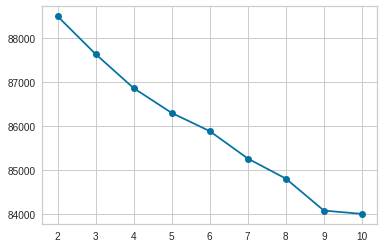

In [24]:
plt.plot(range(2, 11), prod_title_scores_2014['sse'], marker='o', label='sse')

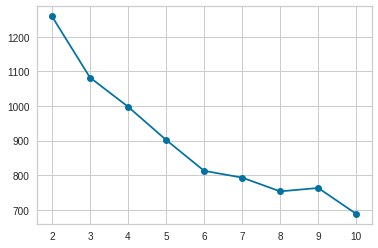

In [25]:
plt.plot(range(2, 11), prod_title_scores_2014['ch'], marker='o', label='ch')

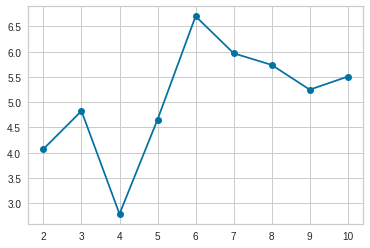

In [26]:
plt.plot(range(2, 11), prod_title_scores_2014['db'], marker='o', label='db')

In [ ]:
# do not run the cell below...

In [55]:
# k-means clustering

sum_of_squared_distances = []
K = range(2, 20)

for k in K:
    start_time = time.time()
    km = KMeans(n_clusters=k, max_iter=600, n_init=10)
    km.fit(prod_title_d_matrix_2014)
    sum_of_squared_distances.append(km.inertia_)
    end_time = time.time()
    
    joblib.dump(end_time-start_time, 'elbowPlot_runtime_dec2014.pkl')

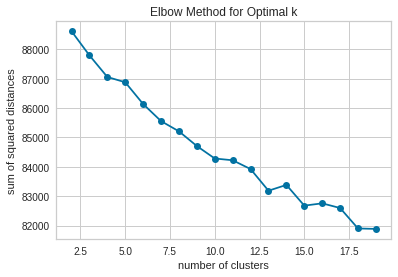

In [56]:
plt.plot(K, sum_of_squared_distances, '-o')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.savefig('ElbowPlot_dec2014.png')
plt.show()

Warning: the `kelbowvisualizer` might take forever...

Metric = distortion or WCSS

In [18]:
dense_2014 = prod_title_d_matrix_2014.sparse.to_dense()

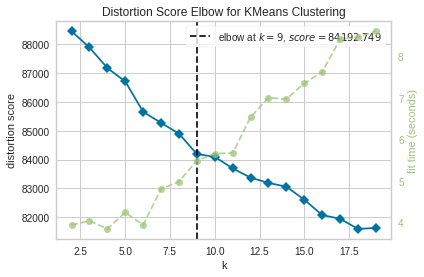

<Figure size 432x288 with 0 Axes>

In [19]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2014, k=(2, 20))
    viz.show(outpath='DistortionScoreElbowPlot_dec2014.png')
    end_time = time.time()
    
    joblib.dump(end_time-start_time, 'DistortionScoreElbowPlot_runtime_dec2014.pkl')

except MemoryError():
    sys.exit()

Metric = silhouette

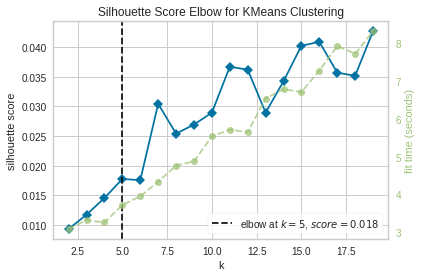

<Figure size 432x288 with 0 Axes>

In [20]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2014, k=(2, 20),
                            metric='silhouette')
    viz.show(outpath='SilhouetteScoreElbowPlot_dec2014.png')
    end_time = time.time()
    
    joblib.dump(end_time-start_time, 'SilhouetteElbowPlot_runtime_dec2014')

except MemoryError():
    sys.exit()

Metric = calinski-harabasz

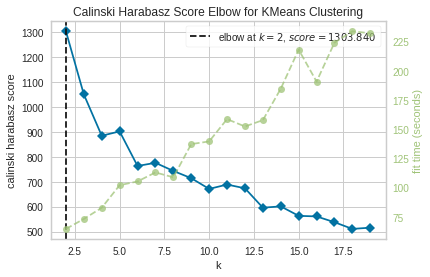

<Figure size 432x288 with 0 Axes>

In [21]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), dense_2014, k=(2, 20),
                      metric='calinski_harabasz')
    viz.show(outpath='CalinskiHarabaszScoreElbowPlot_dec2014.png')
    end_time = time.time()
    
    joblib.dump(end_time-start_time, 'CalinskiHarabaszElbowPlot_runtime_dec2014')
    
except MemoryError():
    sys.exit()

The candidates for the best k-value were `9`, `5` and `2`, using the parameters `metric='distortion'`, `metric='silhouette'`, and `metric='calinski_harabasz'` respectively.

### Transforming the dataset using TruncatedSVD

In [19]:
try:
    try:
        start_time = time.time()
        tsvd_prod_title_2014 = joblib.load('tsvd_prod_title_2014.pkl')
        end_time = time.time()
        
        joblib.dump(end_time-start_time, 'TruncatedSVD_runtime_dec2014')

    except:
        tsvd = TruncatedSVD(n_components=prod_title_d_matrix_2014.shape[1])
        tsvd_prod_title_2014 = tsvd.fit(prod_title_d_matrix_2014)
        joblib.dump(tsvd_prod_title_2014, 'tsvd_prod_title_2014.pkl')
        
        #sv_idx = np.argsort(tsvd_prod_title_2014.explained_variance_ratio_)[::-1]
        #transformed_2014 = tsvd_prod_title_2014[:, sv_idx]

        #joblib.dump(tsvd_prod_title_2014, 'tsvd_prod_title_2014_unsorted')
        #joblib.dump(transformed_2014, 'tsvd_prod_title_2014.pkl')
        #joblib.dump(sv_idx, 'tsvd_sorting_index_2014.pkl')
        
        
except MemoryError():
    sys.exit()

In [20]:
explained_var= tsvd_prod_title_2014.explained_variance_ratio_
explained_var[:10]

array([0.01437155, 0.01027416, 0.01111534, 0.00913061, 0.00929546,
       0.00864064, 0.00751837, 0.00713729, 0.00608683, 0.00524584])

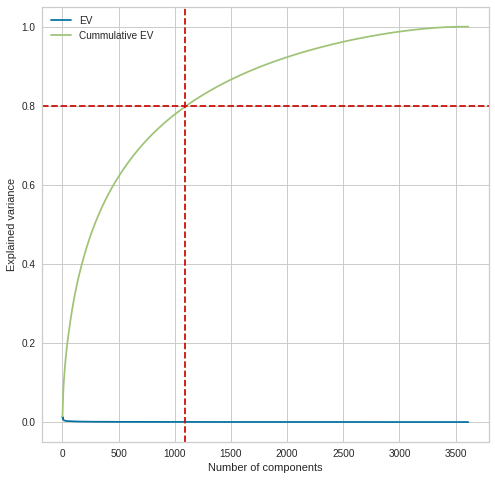

In [21]:
# Make a scree plot
plt.figure(figsize=(8, 8))
n_components = np.arange(1, len(explained_var)+1)
plt.plot(n_components, explained_var, label='EV')
plt.plot(n_components, explained_var.cumsum(), label='Cummulative EV')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
# plt.title("Explained Variance of tSVD-transformed Dataset")

# drawing horizontal and vertical lines
plt.axvline(x=1087, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.legend()

plt.savefig('ScreePlot_prod_title_dec2014.png')
plt.show()

Based on the scree plot, if we keep the first 1087 components of the SVD-transformed dataset, we would still retain 80% of the explained variance....

In [ ]:
# Sort indices
#sv_idx = np.argsort(svd_2014.explained_variance_ratio_)[::-1]
#transformed_2014 = transformed_2014[:, sv_idx]

#save_pkl(svd_2014, 'svd_2014')
#save_pkl(transformed_2014, 'svd_2014')

In [45]:
try:
    start_time = time.time()
    tsvd_prod_title_2014_n = joblib.load('tsvd_prod_title_2014_n.pkl')
    end_time = time.time()
    
    joblib.dump(end_time-start_time, 'TruncatedSVD_runtime_dec2014.pkl')

except:
    n_comp = 1087
    tsvd_n = TruncatedSVD(n_components=n_comp)
    tsvd_prod_title_2014_n = tsvd_n.fit_transform(prod_title_d_matrix_2014)
    joblib.dump(tsvd_prod_title_2014_n, 'tsvd_prod_title_2014_n.pkl')
    
    # Sort indices
    #sv_idx_n = np.argsort(tsvd_prod_title_2014_n.explained_variance_ratio_)[::-1]
    #transformed_2014_n = tsvd_prod_title_2014_n[:, sv_idx]

    #joblib.dump(tsvd_prod_title_2014_n, 'tsvd_prod_title_2014_unsorted.pkl')
    #joblib.dump(transformed_2014_n, 'tsvd_prod_title_2014_n.pkl')
    #joblib.dump(sv_idx_n, 'sorting_index_n_2014.pkl')  

Scatterplot of tSVD-transformed data

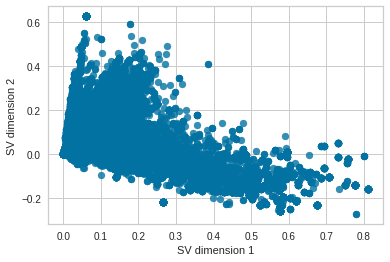

In [30]:
scatter0 = plt.scatter(tsvd_prod_title_2014_n[:, 0],
                       tsvd_prod_title_2014_n[:, 1],
                       cmap='Dark2',
                       alpha=0.8)
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
# plt.title(f'Scatterplot of tSVD-transformed Data')

plt.savefig('TruncSVDPlot_prod_title_dec2014.png')
plt.show();

### Scatterplot using the best `k-values` found

In [48]:
def plot_km(k, data, rs=1337):
    start_time = time.time()
    km = KMeans(k, random_state=rs)
    km.fit(data)
    joblib.dump(km, f'KMeansClusterPlot_k{k}_dec2014.pkl')
    
    scatter1 = plt.scatter(tsvd_prod_title_2014_n[:, 0],
                           tsvd_prod_title_2014_n[:, 1],
                           c=km.labels_,
                           cmap='Dark2')
    joblib.dump(scatter1.legend_elements(), f'KMeansClusterPlot_k{k}_legend_ele_dec2014.pkl')
    plt.legend(*scatter1.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    # plt.title(f'Clusters Found Using K-Means, k={k}')
    plt.savefig(f'KMeansScatterPlot_k{k}_dec2014.png');
    end_time = time.time()
    
    joblib.dump(end_time-start_time, f'KMeansClusterPlot_k{k}_runtime_dec2014.pkl')
    
    return scatter1

In [46]:
best_ks_km = [5, 6, 8]

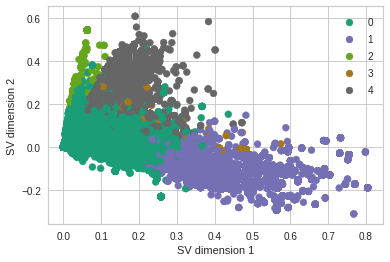

In [49]:
plot_km(k=5, data = tsvd_prod_title_2014_n)

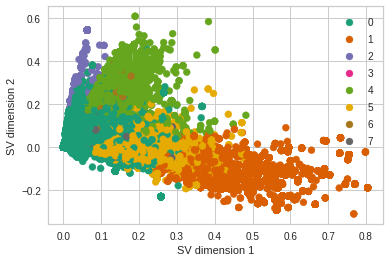

In [52]:
plot_km(k=8, data = tsvd_prod_title_2014_n)

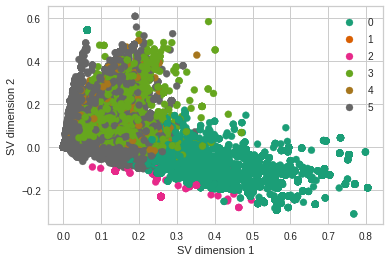

In [50]:
plot_km(k=6, data = tsvd_prod_title_2014_n)

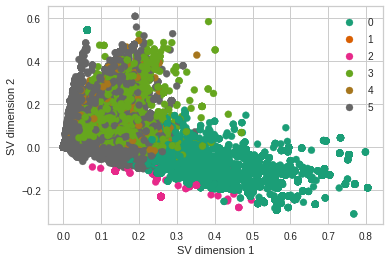

In [51]:
plot_km(k=6, data = tsvd_prod_title_2014_n)

Best number of clusters found: 8

### Visualizing the Clusters

In [57]:
# Get clusters

true_k = 8

start_time = time.time()
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=600, n_init=10)
model.fit(prod_title_d_matrix_2014)
joblib.dump(model, 'final_knn_model_2014.pkl')

# Get prediction/labels
labels = model.labels_

title_cl = pd.DataFrame(list(zip(amz_2014['product_title'], labels)), 
                       columns=['title', 'cluster'])
joblib.dump(title_cl, 'prod_title_cluster_2014.pkl')
end_time = time.time()

joblib.dump(end_time - start_time, 'KMeans_best_k_runtime_dec2014.pkl')

['KMeans_best_k_runtime_dec2014.pkl']

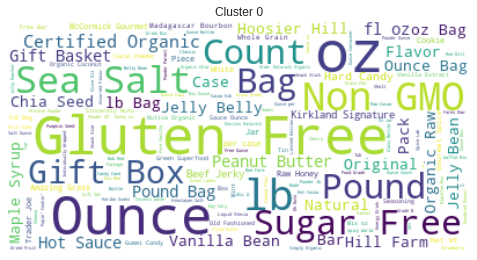

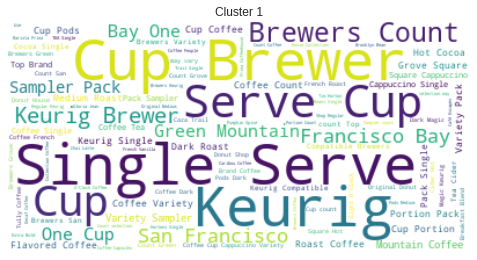

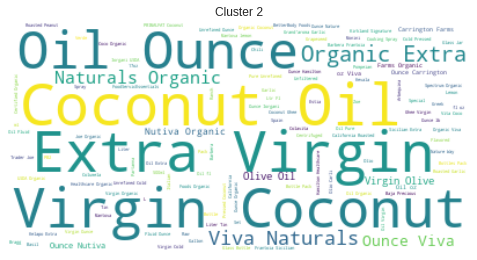

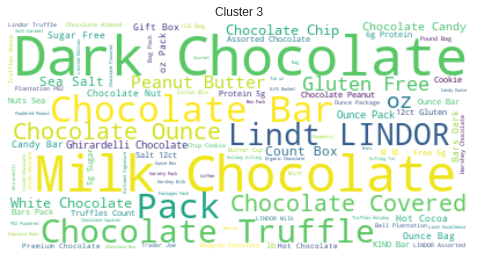

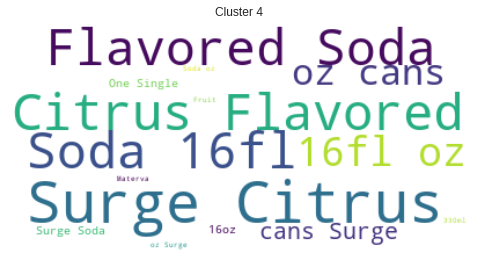

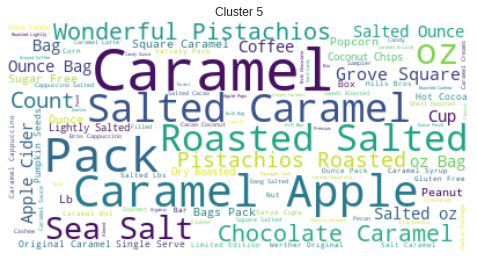

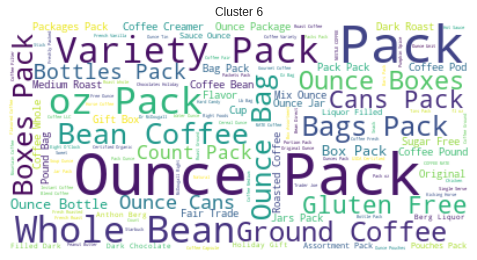

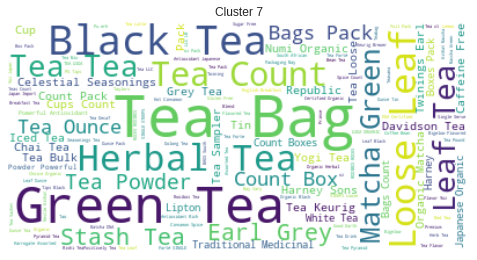

In [58]:
# Visualize the clusters
# Create wordclouds from clusters
from wordcloud import WordCloud

for k in range(true_k):
    start_time = time.time()
    text = title_cl[title_cl.cluster == k].title.str.cat(sep=' ')
    wordcloud = WordCloud(max_font_size=50, max_words=300, 
                          background_color='white').generate(text)
    
    # Create subplot
    plt.figure(figsize=(40, 40))
    plt.subplot(true_k, 2, k+1).set_title('Cluster ' + str(k))
    plt.plot()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('wordcloud_dec2014.png')
    end_time = time.time()
    
    joblib.dump(end_time - start_time, 'wordcloud_runtime_dec2014.pkl')
plt.show()


- cluster0 - healthy options/organic
- cluster1 - coffee
- cluster2 - coconut & olive oil
- cluster3 - chocolate
- cluster4 - soda/fruit juice
- cluster5 - snacks
- cluster6 - packed items
- cluster7 - chocolate
- cluster8 - tea

### Count Vectorizer (unsucessful attempt)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_grams(docs, n=2):
    v = CountVectorizer(ngram_range=(n, n))
    grams = v.fit_transform(docs)
    gram_sum = np.array(np.sum(grams, axis=0)).flatten()
    gram_dict = {i: v for v, i in v.vocabulary_.items()}
    top_grams = gram_sum.argsort()[::1]
    
    return [gram_dict[i] for i in top_grams], gram_sum[top_grams]

In [30]:
doc = ' '.join(df_lemmatized_prod_title_2014['product_title'])

In [31]:
doc[:100]

'chocolate river stones lb bag dave gourmet ultimate insanity hot sauce ounce class bottles pack krus'

In [32]:
ngrams, ngram_counts = {}, {}
for n in [1, 2, 3]:
    #ngrams[n], ngram_counts[n] = get_top_grams[lemmatized_text], n=n
    ngrams[n], ngram_counts[n] = get_top_grams([doc], n=n)

In [33]:
from scipy.stats import zipf
def make_zipf_plot(counts, tokens, a=1.15):
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    normalized_frequencies = counts[indices] / sum(counts)
    f = plt.figure(figsize=(8, 8))
    plt.loglog(ranks, normalized_frequencies, marker=".")
    
    plt.loglog(ranks, [z for z in zipf.pmf(ranks, a)])
    
    plt.title("Zipf Plot")
    plt.xlabel("Word frequency rank")
    plt.ylabel("Word frequency")
    
    ax = plt.gca()
    ax.set_aspect('equal') # make the plot square
    plt.grid(True)
    
    # add text labels
    last_freq = None
    labeled_word_idxs = list(np.logspace(-0.5,
                                         np.log10(len(counts) - 1),
                                         10).astype(int))
    for i in labeled_word_idxs:
        dummy = plt.text(ranks[i],
                         normalized_frequencies[i],
                         " " + tokens[indices[i]],
                         verticalalignment="bottom",
                         horizontalalignment="left")
    plt.show()

In [34]:
ngram_counts

{1: array([    1,     1,     1, ..., 15487, 18105, 22306]),
 2: array([   1,    1,    1, ..., 2482, 2591, 3852]),
 3: array([   1,    1,    1, ...,  998, 1034, 2056])}

In [35]:
make_zipf_plot(ngram_counts, ngrams)

TypeError: bad operand type for unary -: 'dict'

## Hierarchical Clustering (impractical due to large no. of data points)

In [ ]:
# dense_2014 = d_matrix_2014.to_dense()

In [ ]:
# aggloclustering

#sum_of_squared_distances = []
#K = range(2, 20)

#for k in K:
#    aglo = fastcluster.ward(n_clusters=k, max_iter=600, n_init=10)
#    km.fit(d_matrix_2014)
#    sum_of_squared_distances.append(km.inertia_)

### Finding `k` Using `kelbow_visualizer`

Ward's Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2014,
                        k=(2, 20),
                        linkage='ward',
                        show=False)

Complete Linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2014,
                        k=(2, 20),
                        linkage='complete',
                        show=False)

Average Method

In [ ]:
try:
    viz = kelbow_visualizer(AgglomerativeClustering(),
                            dense_2014,
                            k=(2, 20),
                            linkage='average',
                            show=False)
except MemoryError():
    sys.exit()
    

Single-linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2014,
                        k=(2, 20),
                        linkage='single',
                        show=False)

Function for the hierarchical clustering visualizer

In [ ]:
def viz_agglo_elbow(data, linkage='single', k=(2, 20)):
    """
    Find the score elbow for agglomerative clustering using the 
    `kelbow_visualizer` library and generate corresponding elbow plot. 
    """
    viz = kelbow_visualizer(AgglomerativeClustering(), 
                            data, k,linkage=linkage, show=False)
    return viz

### Finding `k` using dendrograms

Ward's Method (interrupted... too long to run)

In [ ]:
dendrogram(fastcluster.linkage(d_matrix_2014, method='ward'), 
           truncate_mode='lastp', 
           #method='ward', 
           p=5,
           optimal_order=False
          )
plt.xlabel('points in cluster')
plt.ylabel('depth')

Complete Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2014), truncate_mode='lastp', 
            method='complete', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Average Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2014), truncate_mode='level', 
            method='average', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Single-linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2014), truncate_mode='level', 
            method='single', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

The best `k` value found was xx using yy method.

### Scatterplot using the best `k` found

In [ ]:
best_k_ac = 6

In [ ]:
ac = AgglomerativeClustering(n_clusters=best_k_ac)
ac.fit(d_matrix_2014.to_numpy())

In [ ]:
scatter2 = plt.scatter(tsvd_2014_n[:, 0],
                       tsvd_2014_n[:, 1],
                       c=ac.labels_,
                       cmap='Dark2')
plt.legend(*scatter2.legend_elements())
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
plt.title(f'Clusters Found Using Agglomerative Methods, best k={best_k_ac}')
plt.show();

## Density-based Clustering (Did not find meaningful clusters)

### DBSCAN

In [ ]:
try:
    core_points = d_matrix_2014.shape[1] * 2
    nn = NearestNeighbors(n_neighbors=core_points + 1)
    nn = nn.fit(d_matrix_2014)
    distances, neighbors = nn.kneighbors(d_matrix_2014)
    average_distances = distances[:, 1:].mean(axis=1)
    average_distances = np.sort(average_distances)
    
    plt.plot(average_distances)
    plt.xlabel('point number')
    plt.ylabel(f'average distance to {core_points} neighbors')
    plt.show();
    
except MemoryError():
    sys.exit()

In [ ]:

kneedle = KneeLocator(range(average_distances.shape[0]),
                      average_distances,
                      curve="concave",
                      direction="increasing")

kneedle.plot_knee()
plt.xlabel('point number')
plt.ylabel(f'average distance to {core_points} neighbors')
plt.show();

eps = average_distances[kneedle.knee]


In [ ]:
print(f'epsilon: {eps}, point no.: {kneedle.knee}')

In [ ]:
try:
    
    db = DBSCAN(eps=eps, min_samples=d_matrix_2014.shape[1]*2, n_jobs=-1)
    db.fit(d_matrix_2014)
    
except MemoryError():
    sys.exit()

In [ ]:
try:

    cluster_labels = db.fit_predict(tsvd_2014_n)
    scatter3 = plt.scatter(tsvd_2014_n[:, 0], 
                           tsvd_2014_n[:, 1], 
                           c=cluster_labels, 
                           cmap='Dark2', s=40)
    plt.legend(*scatter3.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    plt.title(f'Clusters Found Using DBSCAN, k={cluster_labels.max()+1}')

    print('Number of clusters:', cluster_labels.max()+1)
    print('Number of noise points:', (cluster_labels==-1).sum())
    print('Number of points:', len(cluster_labels))
    
except MemoryError():
    sys.exit()


DBSCAN did not find any meaningful clusters.

code from prof's dbscan lecture

In [ ]:
def ave_nn_dist(n_neighbors, data):
    """
    Return the average distance of a point up to its kth nearest
    neighbors from the nearest to farthest.
    """
    from sklearn.neighbors import NearestNeighbors
    kNN_model = NearestNeighbors(n_neighbors=n_neighbors)
    kNN_model.fit(data)
    ave_dist = kNN_model.kneighbors()[0].mean(axis=1)
    
    return np.sort(ave_dist).tolist()

In [ ]:
try:
    ave_dist = ave_nn_dist(7, d_matrix_2014)
    
except MemoryError():
    sys.exit()

In [ ]:
prod_models_2014 = {}
prod_title_scores_2014 = {'sse': [], 'ch': [], 'sh': [], 'db': []}

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=1337)
    cluster_labels = kmeans.fit_predict(docterm_matrix_2014)
    models_2014.update({k: {
        'model': kmeans,
        'labels': cluster_labels,
    }})
    scores_2014['sse'].append(kmeans.inertia_)
    scores_2014['ch'].append(calinski_harabasz_score(
        docterm_matrix_2014.to_numpy(),
        cluster_labels
    ))
#     scores_2014['sh'].append(silhouette_score(
#         docterm_matrix_2014.to_numpy(), cluster_labels
#     ))
    scores_2014['db'].append(davies_bouldin_score(
        docterm_matrix_2014.to_numpy(), cluster_labels
    ))